In [1]:
#Package
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train=pd.read_csv("merged_train.csv")
test=pd.read_csv("merged_test.csv")

In [3]:
# merged_ data에서 drop해야 할 단지코드
print(train.shape, test.shape)
train = train.loc[~train.단지코드.isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']),]
test = test.loc[~test.단지코드.isin(['C2335', 'C1327', 'C2675'])]
print(train.shape, test.shape)

(2952, 34) (1022, 33)
(2896, 34) (1008, 33)


In [4]:
print(len(set(train.단지코드)), len(set(test.단지코드)))

414 147


In [5]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [6]:
print(train.shape, test.shape)

(2577, 34) (936, 33)


In [7]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율'],
      dtype='object')

## 상가비율, 대형전용면적, 총세대수:주차면수, 공가수

In [8]:
print("\n...Before preprocessing")
print(train.shape, test.shape)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 분양세대수 column 추가
train_sale = pd.DataFrame(train.groupby(['단지코드']).first()['총세대수'] - train.groupby(['단지코드']).sum()['전용면적별세대수'])
train_sale.columns = ["분양세대수"]
train_sale = train_sale.astype('int16')
train_sale.reset_index(inplace=True)
train = pd.merge(train, train_sale,on="단지코드")

test_sale = pd.DataFrame(test.groupby(['단지코드']).first()['총세대수'] - test.groupby(['단지코드']).sum()['전용면적별세대수'])
test_sale.columns = ["분양세대수"]
test_sale = test_sale.astype('int16')
test_sale.reset_index(inplace=True)
test = pd.merge(test, test_sale,on="단지코드")

# 세대당_가능주차면수 column 추기
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)


...Before preprocessing
(2577, 34) (936, 33)

...After preprocessing
(2577, 39) (936, 38)


## 위도 경도 NA imputation: 구글맵 사용

### train
    
- 대전둔산3: 36.36376899104686, 127.37073298347131
- 제주아라주공아파트: 33.47376381443057, 126.54686726803892
- 울산송정2: 35.59673220404177, 129.36353989694038

### test

- 정읍첨단1 주거행복복지센터:35.493656, 126.848614

In [9]:
df_tr=pd.DataFrame({'단지명':['대전둔산3', '제주아라주공아파트', '울산송정2'],
                    '위도':[127.37073298347131,126.54686726803892, 129.36353989694038],
                     '경도':[36.36376899104686, 33.47376381443057,35.59673220404177]})
df_tst=pd.DataFrame({'단지명':['정읍첨단1 주거행복복지센터'],'위도':[126.848614],'경도':[35.493656]})

## 자격유형 나누기

In [10]:
train["임대보증금비"]=train.임대보증금/train.임대료
test["임대보증금비"]=test.임대보증금/test.임대료

임대보증금비=pd.concat([round(train.groupby(train.자격유형).임대보증금비.mean()), 
           round(test.groupby(test.자격유형).임대보증금비.median())], axis=1)
임대보증금비.columns=["train", "test"]
임대보증금비

,train,test
A,inf,122.0
B,123.0,NaN
C,66.0,54.0
D,37.0,39.0
E,1920.0,1920.0
F,58.0,NaN
G,57.0,69.0
H,111.0,108.0
I,117.0,104.0
J,218.0,216.0


- A / D 따로 
- C, F, G
- B, H, I
- L, M, N, O
- J
- E, K

In [11]:
dic = {'1': 'A' ,'2':['C','F','G'],'3':['B','H','I'],'4':['J'],'5':['L',"M","N","O"],'6':["E","K"],'7':'D'}

In [12]:
def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

In [13]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)

In [14]:
train=train.drop(['임대보증금비','자격유형'],axis=1)
test=test.drop(['임대보증금비','자격유형'],axis=1)

## New Y
- 등록차량수/총세대수
- 등록차량수/단지내주차면수
- 총세대수/단지내주차면수

## 공급유형

In [15]:
pd.concat([train.공급유형.value_counts(), test.공급유형.value_counts()], axis=1)

,공급유형,공급유형
국민임대,1708,611.0
임대상가,286,112.0
행복주택,192,118.0
공공임대(10년),180,34.0
영구임대,149,42.0
공공임대(50년),31,13.0
공공임대(분납),12,6.0
장기전세,9,NaN
공공분양,7,NaN
공공임대(5년),3,NaN


In [16]:
train["공급유형_"]=train.공급유형
test["공급유형_"]=test.공급유형

In [17]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)','공공임대(분납)']), '공급유형'] = '공공임대_통합'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)','공공임대(분납)']), '공급유형'] = '공공임대_통합'

In [18]:
공공임대_tr=train[train.공급유형=="공공임대_통합"]
공공임대_tst=test[test.공급유형=="공공임대_통합"]

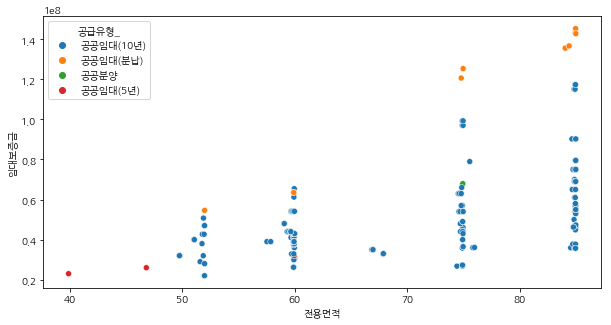

In [19]:
plt.subplots(figsize=(10,5))
sns.scatterplot(x="전용면적", y="임대보증금", data=공공임대_tr, hue="공급유형_")

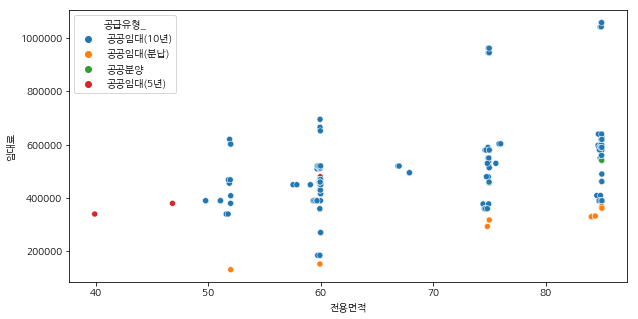

In [20]:
plt.subplots(figsize=(10,5))
sns.scatterplot(x="전용면적", y="임대료", data=공공임대_tr, hue="공급유형_")

- 공공임대(5년), 공공임대(10년)만 묶으면 될 듯
- 그 외 장기전세 등도 확인해봤는데 너무 분포가 다름. 

In [21]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

In [22]:
train=train.drop("공급유형_", axis=1)
test=test.drop("공급유형_", axis=1)

# 지역 나누기

- random effect model?
- Linear Regression?

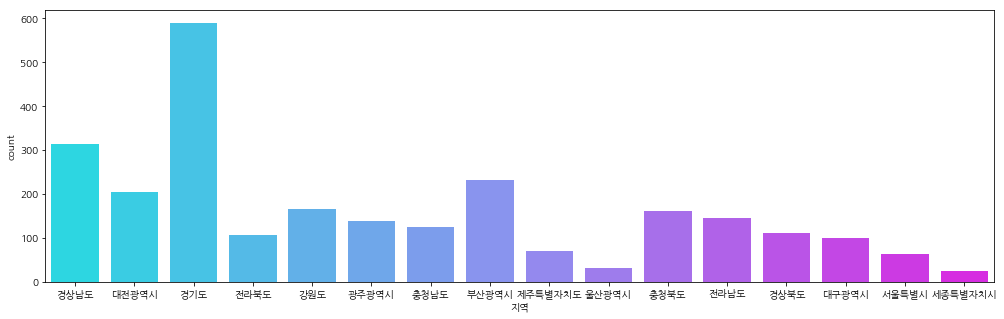

In [23]:
plt.subplots(figsize=(17,5))
sns.countplot(x=train["지역"],palette="cool")

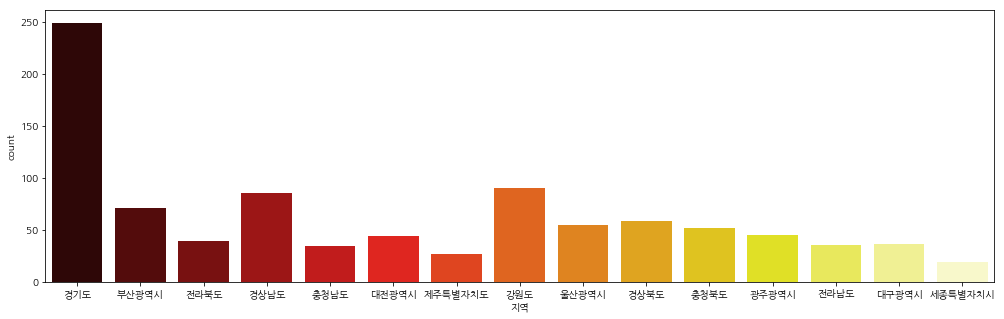

In [24]:
plt.subplots(figsize=(17,5))
sns.countplot(x=test["지역"],palette="hot")

In [25]:
pd.concat([train.지역.value_counts(), test.지역.value_counts()], axis=1)

,지역,지역
경기도,590,249.0
경상남도,314,85.0
부산광역시,232,71.0
대전광역시,203,44.0
강원도,166,90.0
충청북도,161,51.0
전라남도,145,35.0
광주광역시,139,45.0
충청남도,125,34.0
경상북도,110,58.0


In [26]:
pd.DataFrame(train["등록차량수"].unique()).describe()

,0
count,349.000000
mean,589.455587
std,408.319033
min,13.000000
25%,296.000000
50%,520.000000
75%,795.000000
max,2550.000000


In [27]:
pd.concat([pd.DataFrame(train["단지내주차면수"].unique()).describe(),
           pd.DataFrame(test["단지내주차면수"].unique()).describe()], axis=1)

,0,0
count,351.000000,140.000000
mean,615.504274,562.371429
std,376.884005,320.055196
min,13.000000,29.000000
25%,331.500000,318.500000
50%,546.000000,511.500000
75%,843.500000,742.250000
max,1798.000000,1696.000000


In [28]:
pd.concat([round(pd.DataFrame(train["임대료"].unique()).describe()),
           round(pd.DataFrame(test["임대료"].unique()).describe())], axis=1)

,0,0
count,1251.0,495.0
mean,798507.0,388786.0
std,3523873.0,2203953.0
min,0.0,17420.0
25%,116975.0,107935.0
50%,167000.0,159960.0
75%,259505.0,233020.0
max,81594000.0,38188331.0


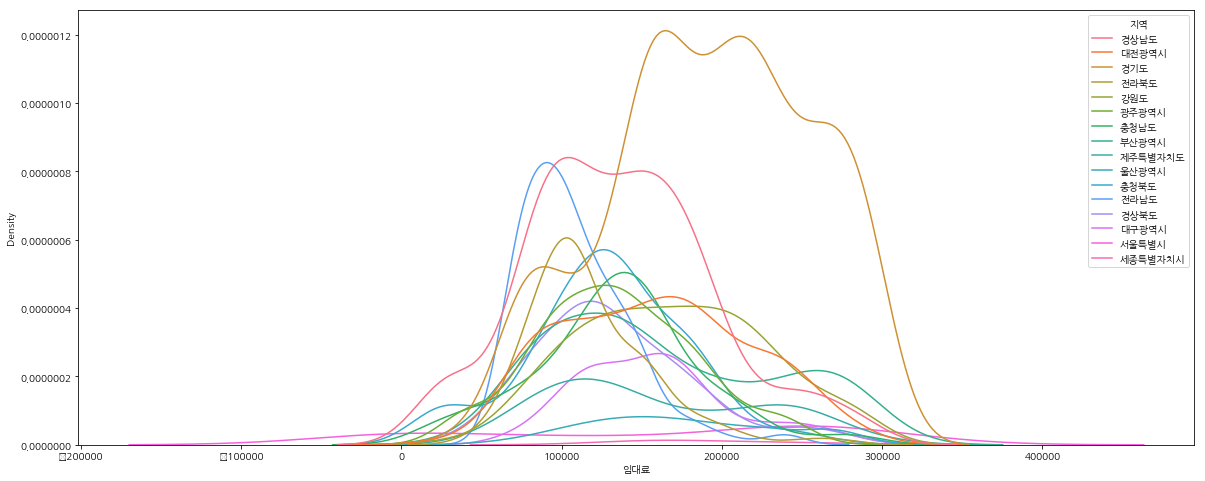

In [29]:
tmp = train[train.임대료<300000]
plt.rcParams["figure.figsize"] = (20,8)
sns.kdeplot(data=tmp,x='임대료',color='black',hue='지역')
plt.show()

In [30]:
pd.concat([round(pd.DataFrame(train["임대보증금"].unique()).describe()),
           round(pd.DataFrame(test["임대보증금"].unique()).describe())], axis=1)

,0,0
count,1214.0,498.0
mean,23962707.0,22829666.0
std,28049484.0,17903910.0
min,25600.0,643425.0
25%,9716538.0,10881750.0
50%,17099000.0,18260500.0
75%,27308250.0,28809250.0
max,395801928.0,144496000.0


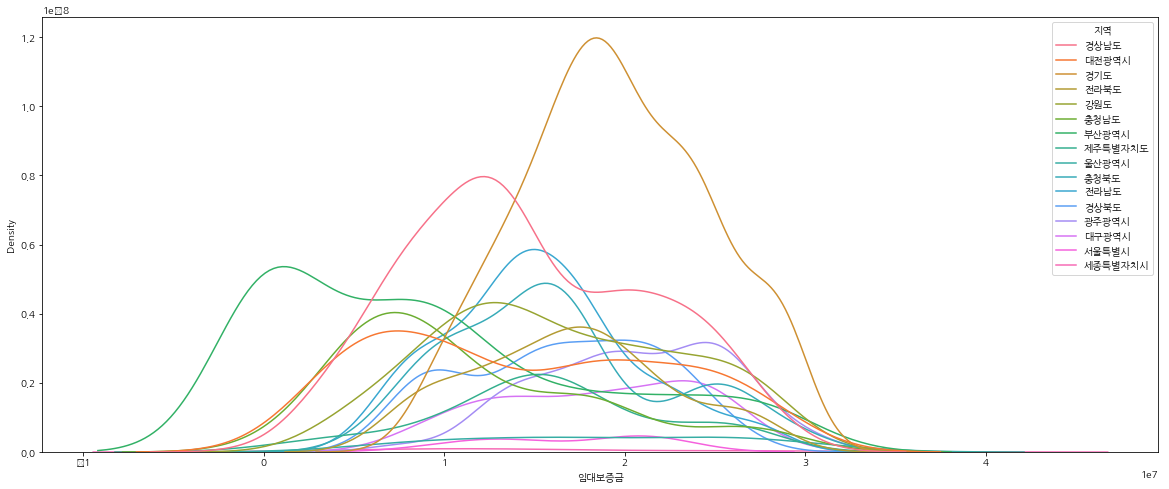

In [31]:
tmp = train[train.임대보증금<30000000]
plt.rcParams["figure.figsize"] = (20,8)
sns.kdeplot(data=tmp,x='임대보증금',color='black',hue='지역')
plt.show()

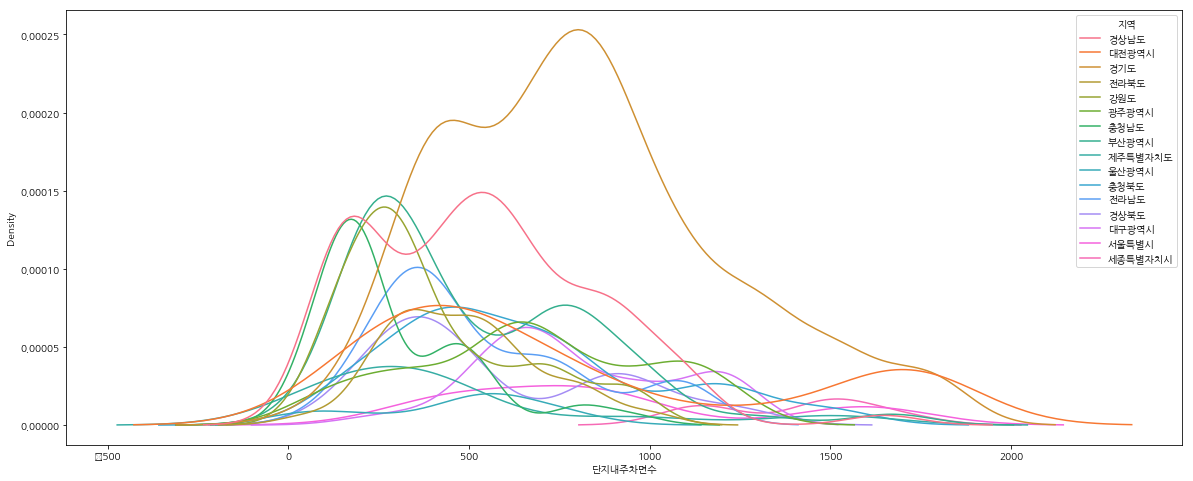

In [32]:
tmp = train
plt.rcParams["figure.figsize"] = (20,8)
sns.kdeplot(data=tmp,x='단지내주차면수',color='black',hue='지역')
plt.show()

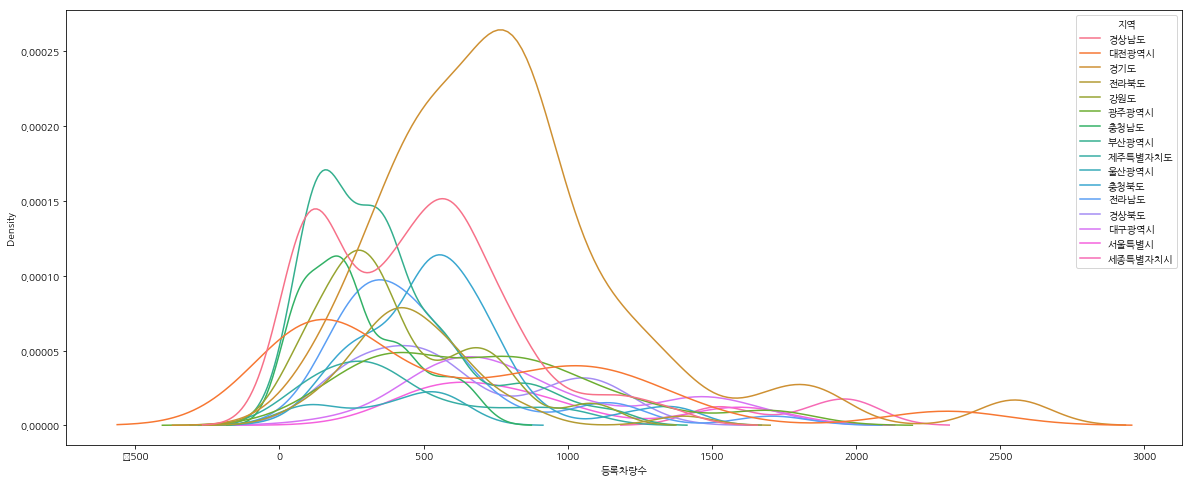

In [33]:
tmp = train
plt.rcParams["figure.figsize"] = (20,8)
sns.kdeplot(data=tmp,x='등록차량수',color='black',hue='지역')
plt.show()

## 지역 별로 준비한 주차면수가 얼마나 부족한가?

In [34]:
train["주차면수비"]=train.등록차량수/train.단지내주차면수
train["임대보증금비"]=train.임대보증금/train.임대료

In [35]:
df=train[["지역","임대료","임대보증금",
          "단지내주차면수","등록차량수", 
          "임대보증금비","주차면수비"]].groupby('지역').median()
# agg(['mean','median']))

In [36]:
df

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
강원도,172235.000000,1.615700e+07,296.0,322.0,90.960299,1.020270
경기도,217210.000000,2.821400e+07,779.0,763.0,132.351539,1.039773
경상남도,145890.000000,1.546730e+07,515.0,479.0,114.581494,0.800235
경상북도,126700.000000,1.730200e+07,409.0,562.0,135.002775,1.103093
광주광역시,135960.000000,2.477500e+07,658.0,713.0,178.791159,1.134868
대구광역시,173840.000000,2.409300e+07,728.0,744.0,116.328987,1.120482
대전광역시,184478.225098,1.867200e+07,548.0,373.0,81.396767,0.720000
부산광역시,241560.000000,9.363000e+06,405.0,345.0,67.635982,0.645914
서울특별시,281700.000000,6.960000e+07,877.0,793.0,121.263391,1.003145


In [37]:
df.loc[df.주차면수비>1.1]

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
경상북도,126700.0,17302000.0,409.0,562.0,135.002775,1.103093
광주광역시,135960.0,24775000.0,658.0,713.0,178.791159,1.134868
대구광역시,173840.0,24093000.0,728.0,744.0,116.328987,1.120482
세종특별자치시,470000.0,43000000.0,1500.0,1832.0,90.290135,1.322000


In [38]:
df.loc[df.주차면수비<=1.1][df.주차면수비>1]

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
강원도,172235.0,16157000.0,296.0,322.0,90.960299,1.020270
경기도,217210.0,28214000.0,779.0,763.0,132.351539,1.039773
서울특별시,281700.0,69600000.0,877.0,793.0,121.263391,1.003145
전라남도,100920.0,14863000.0,421.0,408.0,142.865636,1.040909


In [39]:
df.loc[df.주차면수비<=1][df.주차면수비>0.9]

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
울산광역시,174745.0,24775000.0,486.0,396.0,127.280734,0.929432
전라북도,110310.0,17342000.0,472.0,415.0,164.722644,0.940184
제주특별자치도,141000.0,15620000.0,376.0,358.0,115.327137,0.954787
충청남도,136550.0,10060000.0,200.0,209.0,69.545668,0.962025
충청북도,134570.0,16581000.0,550.0,553.0,113.851351,0.958106


In [40]:
df.loc[df.주차면수비<=0.9]

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
경상남도,145890.000000,1.546730e+07,515.0,479.0,114.581494,0.800235
대전광역시,184478.225098,1.867200e+07,548.0,373.0,81.396767,0.720000
부산광역시,241560.000000,9.363000e+06,405.0,345.0,67.635982,0.645914


In [41]:
train["지역_1"]=train.지역
test["지역_1"]=test.지역

In [42]:
train.loc[train.지역.isin(['경상북도', '광주광역시', '대구광역시', '세종특별자치시']), '지역_1'] = '지역1'
train.loc[train.지역.isin(['강원도', '경기도', '서울특별시','전라남도']), '지역_1'] = '지역2'
train.loc[train.지역.isin(['울산광역시', '전라북도', '제주특별자치도','충청남도',"충청북도"]), '지역_1'] = '지역3'
train.loc[train.지역.isin(['경상남도', '대전광역시', '부산광역시']), '지역_1'] = '지역4'

test.loc[test.지역.isin(['경상북도', '광주광역시', '대구광역시', '세종특별자치시']), '지역_1'] = '지역1'
test.loc[test.지역.isin(['강원도', '경기도', '서울특별시','전라남도']), '지역_1'] = '지역2'
test.loc[test.지역.isin(['울산광역시', '전라북도', '제주특별자치도','충청남도',"충청북도"]), '지역_1'] = '지역3'
test.loc[test.지역.isin(['경상남도', '대전광역시', '부산광역시']), '지역_1'] = '지역4'

# 등록차량수로 나누기

In [43]:
pd.DataFrame(train["등록차량수"].unique()).describe()

,0
count,349.000000
mean,589.455587
std,408.319033
min,13.000000
25%,296.000000
50%,520.000000
75%,795.000000
max,2550.000000


In [44]:
df

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
강원도,172235.000000,1.615700e+07,296.0,322.0,90.960299,1.020270
경기도,217210.000000,2.821400e+07,779.0,763.0,132.351539,1.039773
경상남도,145890.000000,1.546730e+07,515.0,479.0,114.581494,0.800235
경상북도,126700.000000,1.730200e+07,409.0,562.0,135.002775,1.103093
광주광역시,135960.000000,2.477500e+07,658.0,713.0,178.791159,1.134868
대구광역시,173840.000000,2.409300e+07,728.0,744.0,116.328987,1.120482
대전광역시,184478.225098,1.867200e+07,548.0,373.0,81.396767,0.720000
부산광역시,241560.000000,9.363000e+06,405.0,345.0,67.635982,0.645914
서울특별시,281700.000000,6.960000e+07,877.0,793.0,121.263391,1.003145


In [45]:
df.loc[df.등록차량수<=400]

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
강원도,172235.000000,16157000.0,296.0,322.0,90.960299,1.020270
대전광역시,184478.225098,18672000.0,548.0,373.0,81.396767,0.720000
부산광역시,241560.000000,9363000.0,405.0,345.0,67.635982,0.645914
울산광역시,174745.000000,24775000.0,486.0,396.0,127.280734,0.929432
제주특별자치도,141000.000000,15620000.0,376.0,358.0,115.327137,0.954787
충청남도,136550.000000,10060000.0,200.0,209.0,69.545668,0.962025


In [46]:
df.loc[df.등록차량수>400][df.등록차량수<=650]

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
경상남도,145890.0,1.546730e+07,515.0,479.0,114.581494,0.800235
경상북도,126700.0,1.730200e+07,409.0,562.0,135.002775,1.103093
전라남도,100920.0,1.486300e+07,421.0,408.0,142.865636,1.040909
전라북도,110310.0,1.734200e+07,472.0,415.0,164.722644,0.940184
충청북도,134570.0,1.658100e+07,550.0,553.0,113.851351,0.958106


In [47]:
df.loc[df.등록차량수>650]

,임대료,임대보증금,단지내주차면수,등록차량수,임대보증금비,주차면수비
지역,,,,,,
경기도,217210.0,28214000.0,779.0,763.0,132.351539,1.039773
광주광역시,135960.0,24775000.0,658.0,713.0,178.791159,1.134868
대구광역시,173840.0,24093000.0,728.0,744.0,116.328987,1.120482
서울특별시,281700.0,69600000.0,877.0,793.0,121.263391,1.003145
세종특별자치시,470000.0,43000000.0,1500.0,1832.0,90.290135,1.322000


In [48]:
train["지역_2"]=train.지역
test["지역_2"]=test.지역

In [49]:
train.loc[train.지역.isin(['강원도', '대전광역시', '부산광역시','울산광역시', '제주특별자치도','충청남도']), '지역_2'] = '지역1'
train.loc[train.지역.isin(['경상남도', '경상북도', '전라남도','전라북도','충청북도']), '지역_2'] = '지역2'
train.loc[train.지역.isin(['경기도', '광주광역시', '대구광역시','서울특별시',"세종특별자치시"]), '지역_2'] = '지역3'

test.loc[test.지역.isin(['강원도', '대전광역시', '부산광역시','울산광역시', '제주특별자치도','충청남도']), '지역_2'] = '지역1'
test.loc[test.지역.isin(['경상남도', '경상북도', '전라남도','전라북도','충청북도']), '지역_2'] = '지역2'
test.loc[test.지역.isin(['경기도', '광주광역시', '대구광역시','서울특별시',"세종특별자치시"]), '지역_2'] = '지역3'

In [50]:
train=train.drop(["주차면수비","임대보증금비"], axis=1)

## 다른 후보
- 광역시: 부산광역시, 대전광역시, 광주광역시, 대구광역시, 울산광역시
- 경기도, 서울특별시, 세종특별자치시
- 충청도: 충청남도, 
- 경상도: 경상남도, 경상북도
- 전라도: 전라남도, 전라북도
- 제주도
- 세종특별자치시


# Modeling

In [51]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 

In [53]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명', '도로명주소',
       '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수', '총인구수',
       '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상',
       '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '분양세대수',
       '세대당_가능주차면수', '공가수비율', '대형전용면적', '자격유형_카테고리', '지역_1', '지역_2'],
      dtype='object')

# correlation 확인

In [54]:
X_cor = train.drop(columns=['단지코드','단지명','도로명주소','subway_name','공급유형','자격유형_카테고리','지역'])
X_cor = pd.get_dummies(X_cor, drop_first=True)

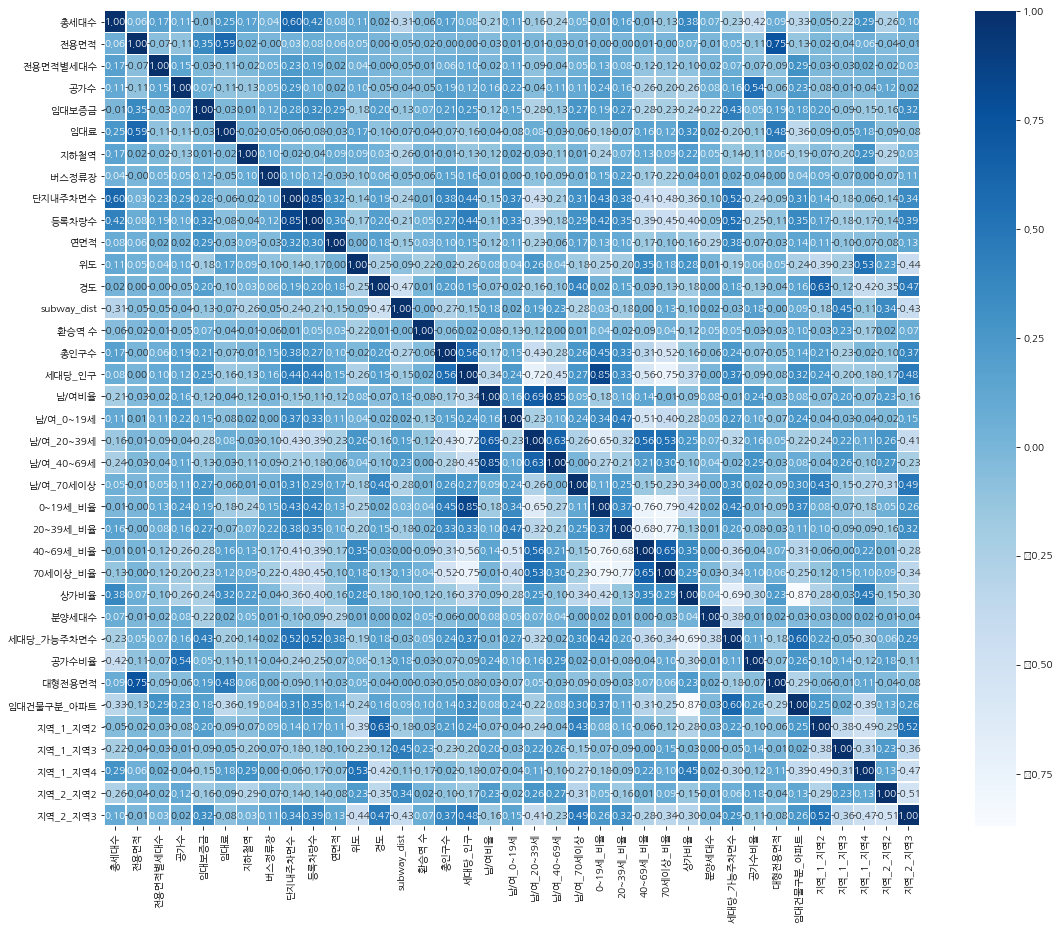

In [55]:
plt.subplots(figsize=(20,15))
sns.heatmap(X_cor.corr(), cbar = True, annot = True, fmt = '.2f', square = True, cmap = 'Blues', linewidths=.5)

## 기본으로 돌려보기

In [56]:
X = train.drop(columns=['단지코드','단지명','도로명주소','subway_name','등록차량수', '전용면적','지역_1','지역_2'])
y = train[['등록차량수']]

In [57]:
X = pd.get_dummies(X, drop_first=True)

In [58]:
len(X.columns)

57

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [60]:
from sklearn.linear_model import LinearRegression

In [61]:
lr= LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
mean_absolute_error(y_test, lr_pred)

118.62611987900372

In [62]:
ri = Ridge().fit(X_train, y_train)
ri_pred = ri.predict(X_test)
mean_absolute_error(y_test, ri_pred)

119.11582275405846

In [63]:
la = Lasso().fit(X_train, y_train)
la_pred = la.predict(X_test)
mean_absolute_error(y_test, la_pred)

123.61493502425066

In [64]:
rf = RandomForestRegressor(random_state=2021, criterion="mae").fit(X_train, y_train)
rf_pred = rf.predict(X_test)
mean_absolute_error(y_test, rf_pred)

13.603843669250645

In [65]:
dc = DecisionTreeRegressor(random_state=2021, criterion="mae").fit(X_train, y_train)
dc_pred = dc.predict(X_test)
mean_absolute_error(y_test, dc_pred)

9.94702842377261

## 지역별로 나눠서 modeling

In [66]:
train1=train[train.지역_1=="지역1"]
train2=train[train.지역_1=="지역2"]
train3=train[train.지역_1=="지역3"]
train4=train[train.지역_1=="지역4"]

In [67]:
test1=test[test.지역_1=="지역1"]
test2=test[test.지역_1=="지역2"]
test3=test[test.지역_1=="지역3"]
test4=train[train.지역_1=="지역4"]

In [68]:
print(train1.shape, train2.shape, train3.shape, train4.shape)
print(test1.shape, test2.shape, test3.shape, test4.shape)

(372, 41) (964, 41) (492, 41)
(158, 40) (374, 40) (204, 40)


In [69]:
X = train3.drop(columns=['단지코드','단지명','도로명주소','subway_name','등록차량수', '전용면적','지역_1','지역_2'])
y = train3[['등록차량수']]
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)

In [70]:
#minMaxScaler.fit(X_train)
#X_train = minMaxScaler.transform(X_train)
#minMaxScaler.fit(X_test)
#X_test = minMaxScaler.transform(X_test)
# 왜인지 스케일러 쓰면 안좋아짐;;

In [71]:
lr= LinearRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
mean_absolute_error(y_test, lr_pred)

69.59810811690382

In [72]:
ri = Ridge().fit(X_train, y_train)
ri_pred = ri.predict(X_test)
mean_absolute_error(y_test, ri_pred)

70.63799764166745

In [73]:
la = Lasso().fit(X_train, y_train)
la_pred = la.predict(X_test)
mean_absolute_error(y_test, la_pred)

74.72658899186169

# 첫번째 기준으로 예측 해보겠음

In [53]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [54]:
# sample = sample.loc[~sample.code.isin(['C2335', 'C1327', 'C2675'])]

In [55]:
sample.shape

(150, 2)

In [56]:
train1=train[train.지역_1=="지역1"]
train2=train[train.지역_1=="지역2"]
train3=train[train.지역_1=="지역3"]
train4=train[train.지역_1=="지역4"]
test1=test[test.지역_1=="지역1"]
test2=test[test.지역_1=="지역2"]
test3=test[test.지역_1=="지역3"]
test4=test[test.지역_1=="지역4"]

In [57]:
print(train1.shape, train2.shape, train3.shape, train4.shape)
print(test1.shape, test2.shape, test3.shape, test4.shape)

(372, 41) (964, 41) (492, 41) (749, 41)
(158, 40) (374, 40) (204, 40) (200, 40)


In [58]:
df= pd.concat([train1, test1])

In [59]:
X = df.drop(columns=['단지코드','단지명','도로명주소','subway_name','등록차량수', '전용면적','지역_1','지역_2'])
X = pd.get_dummies(X, drop_first=True)

In [60]:
X.train=X.iloc[0:372, :]
X.test=X.iloc[372:, :]
y_train = train1[['등록차량수']]

In [61]:
model1= LinearRegression().fit(X.train, y_train)
model1_pred = model1.predict(X.test)

In [62]:
model1=pd.DataFrame(model1_pred)
code1=test1.단지코드
model1=model1.reset_index(drop=True)
code1=code1.reset_index(drop=True)

In [63]:
pred1=pd.concat([code1, model1], axis=1, ignore_index=True)
pred1.columns=["code", "num"]
pred1=pred1.num.groupby(pred1.code).mean()
pred1.head()

code
C1071     313.553891
C1229     184.582695
C1253    1077.292590
C1297     410.488727
C1349     300.984831
Name: num, dtype: float64

In [64]:
df= pd.concat([train2, test2])

In [65]:
X = df.drop(columns=['단지코드','단지명','도로명주소','subway_name','등록차량수', '전용면적','지역_1','지역_2'])
X = pd.get_dummies(X, drop_first=True)

In [66]:
X.train=X.iloc[0:964, :]
X.test=X.iloc[964:, :]
y_train = train2[['등록차량수']]

In [67]:
model2= LinearRegression().fit(X.train, y_train)
model2_pred = model2.predict(X.test)

In [68]:
model2=pd.DataFrame(model2_pred)
code2=test2.단지코드
model2=model2.reset_index(drop=True)
code2=code2.reset_index(drop=True)

In [69]:
pred2=pd.concat([code2, model2], axis=1, ignore_index=True)
pred2.columns=["code", "num"]
pred2=pred2.num.groupby(pred2.code).mean()
pred2.head()

code
C1016    696.600865
C1030    860.896840
C1060    726.832686
C1064    778.435719
C1072    647.426512
Name: num, dtype: float64

In [70]:
df= pd.concat([train3, test3])

In [71]:
X = df.drop(columns=['단지코드','단지명','도로명주소','subway_name','등록차량수', '전용면적','지역_1','지역_2'])
X = pd.get_dummies(X, drop_first=True)

In [72]:
X.train=X.iloc[0:492, :]
X.test=X.iloc[492:, :]
y_train = train3[['등록차량수']]

In [73]:
model3= LinearRegression().fit(X.train, y_train)
model3_pred = model3.predict(X.test)

In [74]:
model3=pd.DataFrame(model3_pred)
code3=test3.단지코드
model3=model3.reset_index(drop=True)
code3=code3.reset_index(drop=True)

In [75]:
pred3=pd.concat([code3, model3], axis=1, ignore_index=True)
pred3.columns=["code", "num"]
pred3=pred3.num.groupby(pred3.code).mean()
pred3.head()

code
C1019    298.560777
C1038    207.365789
C1040    330.304863
C1166    283.165261
C1216    288.283158
Name: num, dtype: float64

In [76]:
df= pd.concat([train4, test4])

In [77]:
X = df.drop(columns=['단지코드','단지명','도로명주소','subway_name','등록차량수', '전용면적','지역_1','지역_2'])
X = pd.get_dummies(X, drop_first=True)

In [78]:
X.train=X.iloc[0:749, :]
X.test=X.iloc[749:, :]
y_train = train4[['등록차량수']]

In [79]:
model4= LinearRegression().fit(X.train, y_train)
model4_pred = model4.predict(X.test)

In [80]:
model4=pd.DataFrame(model4_pred)
code4=test4.단지코드
model4=model4.reset_index(drop=True)
code4=code4.reset_index(drop=True)

In [81]:
pred4=pd.concat([code4, model4], axis=1, ignore_index=True)
pred4.columns=["code", "num"]
pred4=pred4.num.groupby(pred4.code).mean()
pred4.head()

code
C1003    193.503464
C1006    306.998581
C1083    392.254068
C1147    686.433126
C1152    826.335952
Name: num, dtype: float64

In [82]:
df_merge=pd.DataFrame(pd.concat([pred1, pred2, pred3, pred4], axis=0))
df_merge=df_merge.reset_index()

In [83]:
df_merge.head()

,code,num
0,C1071,313.553891
1,C1229,184.582695
2,C1253,1077.292590
3,C1297,410.488727
4,C1349,300.984831


In [84]:
test_split=pd.merge(sample, df_merge, on='code', how='outer')

In [85]:
test_split.head()

,code,num_x,num_y
0,C1072,0,647.426512
1,C1128,0,1314.354282
2,C1456,0,552.360620
3,C1840,0,534.254879
4,C1332,0,1213.827328


In [86]:
test_split= test_split.drop(columns='num_x')
test_split.columns=["code","num"]

In [87]:
min(train.등록차량수)

13.0

In [88]:
test_split[test_split.num<0].index

Int64Index([116, 128, 147], dtype='int64')

In [89]:
test_split.at[116,"num"]=13
test_split.at[128,"num"]=13
test_split.at[147,'num']=13

In [90]:
test_split.to_csv('0712_LR.csv', index=False)